In [7]:
import torch

# Домашняя + практическая работа 2

## Задание. 

Реализуйте backward для Polynomial 0.5 * (5 * input ** 3 - 3 * input)

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Function

In [9]:
def show_tensor_params(*tensors):
  for x in tensors:
    print('---')
    print(f"data - {x.data}")
    print(f"grad - {x.grad}")
    print(f"grad_fn - {x.grad_fn}")
    print(f"req_grad - {x.requires_grad}")
    print(f"is_leaf - {x.is_leaf}")

In [10]:
import torch


class Polynomial(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return (7.5 * input ** 2 - 1.5) * grad_output

In [11]:
input = torch.tensor(1., requires_grad=True)
output = Polynomial.apply(input)
output

tensor(1., grad_fn=<PolynomialBackward>)

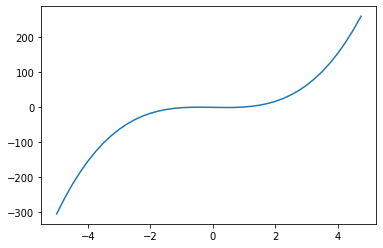

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = Polynomial.apply(xs)
plt.plot(xs, ys)

In [13]:
output.backward()
show_tensor_params(output)
x = show_tensor_params(input)
x

---
data - 1.0
grad - None
grad_fn - <torch.autograd.function.PolynomialBackward object at 0x7fcacf3876d0>
req_grad - True
is_leaf - False
---
data - 1.0
grad - 6.0
grad_fn - None
req_grad - True
is_leaf - True


<ipython-input-9-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print(f"grad - {x.grad}")


## Создание собственной библиотеки автоматического дифференцирования

Написать собственный движок автоматического дифференцирования.

In [14]:
class Value:
	""" stores a single scalar value and its gradient """

	def __init__(self, data, _children=(), _op=''):
		self.data = data
		self.grad = 0
		# internal variables used for autograd graph construction
		self._backward = lambda: None  # function
		self._prev = set(_children)  # set of Value objects
		self._op = _op  # the op that produced this node, string ('+', '-', ....)

	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')

		def _backward():
			self.grad += out.grad
			other.grad += out.grad

		out._backward = _backward

		return out

	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')

		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad

		out._backward = _backward

		return out

	def __pow__(self, other):
		assert isinstance(other, (int, float)), "only supporting int/float powers for now"
		out = Value(self.data ** other, (self,), f'**{other}')

		def _backward():
			self.grad += other * self.data ** (other - 1) * out.grad

		out._backward = _backward

		return out

	def relu(self):
		out = Value(self.data if self.data > 0 else 0, (self,), 'relu')

		def _backward():
			self.grad += out.grad if self.data > 0 else 0

		out._backward = _backward

		return out

	def backward(self):

		# topological order all of the children in the graph
		topo = []
		visited = set()

		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)

		build_topo(self)

		# go one variable at a time and apply the chain rule to get its gradient
		self.grad = 1
		for v in reversed(topo):
			v._backward()

	def __neg__(self):  # -self
		return self * -1

	def __radd__(self, other):  # other + self
		return self + other

	def __sub__(self, other):  # self - other
		return self + (-other)

	def __rsub__(self, other):  # other - self
		return other + (-self)

	def __rmul__(self, other):  # other * self
		return self * other

	def __truediv__(self, other):  # self / other
		return self * other ** -1

	def __rtruediv__(self, other):  # other / self
		return other * self ** -1

	def __repr__(self):
		return f"Value(data={self.data}, grad={self.grad})"


In [15]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
  
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    
    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    # print(xmg, xpt, xpt.grad)
    assert xmg.grad == xpt.grad.item()
    print("test_sanity_check passed")

def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol
    print("test_more_ops passed")

In [17]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)

In [18]:
c = a + b
e = c * d
e.backward()

In [19]:
test_sanity_check()

test_sanity_check passed


In [20]:
test_more_ops()

test_more_ops passed


## Обучение на основе собственной бибилотеки

### Многослойный перцептрон на основе класса Value

In [21]:
import random


class Module:

	def zero_grad(self):
		for p in self.parameters():
			p.grad = 0

	def parameters(self):
		return []


class Neuron(Module):

	def __init__(self, nin, nonlin=True):
		self.w = [Value(random.random()) for _ in range(nin)]
		self.b = Value(random.random())
		self.nonlin = nonlin

	def __call__(self, x):
		act = sum(w * xi for w, xi in zip(self.w, x)) + self.b
		return act.relu() if self.nonlin else act

	def parameters(self):
		return self.w + [self.b]

	def __repr__(self):
		return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"


class Layer(Module):

	def __init__(self, nin, nout, **kwargs):
		self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

	def __call__(self, x):
		out = [n(x) for n in self.neurons]
		return out[0] if len(out) == 1 else out

	def parameters(self):
		return [p for n in self.neurons for p in n.parameters()]

	def __repr__(self):
		return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):

	def __init__(self, nin, nouts):
		sz = [nin] + nouts
		self.layers = [Layer(sz[i], sz[i + 1], nonlin=(i != len(nouts) - 1)) for i in range(len(nouts))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x

	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

	def __repr__(self):
		repr = '\n'.join(str(layer) for layer in self.layers)
		return f"MLP of [{repr}]"


### Обучение многослойного перцептрона

In [22]:
model = MLP(3, [4, 4, 1])
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)]
Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)]
Layer of [LinearNeuron(4)]]
number of parameters 41


In [23]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [24]:
for k in range(50):

	# forward
	loss = 0
	for x, y in zip(xs, ys):
		y_hat = model(x)
		loss += (y_hat - y) ** 2

	# backward
	model.zero_grad()
	loss.backward()

	for p in model.parameters():
		p.data -= 0.01 * p.grad
	print(f"loss = {loss.data:.3f}")


loss = 591.087
loss = 6.271
loss = 4.288
loss = 4.244
loss = 4.206
loss = 4.175
loss = 4.148
loss = 4.125
loss = 4.106
loss = 4.090
loss = 4.076
loss = 4.064
loss = 4.054
loss = 4.046
loss = 4.039
loss = 4.033
loss = 4.028
loss = 4.024
loss = 4.020
loss = 4.017
loss = 4.014
loss = 4.012
loss = 4.010
loss = 4.009
loss = 4.007
loss = 4.006
loss = 4.005
loss = 4.004
loss = 4.004
loss = 4.003
loss = 4.003
loss = 4.002
loss = 4.002
loss = 4.002
loss = 4.001
loss = 4.001
loss = 4.001
loss = 4.001
loss = 4.001
loss = 4.001
loss = 4.001
loss = 4.000
loss = 4.000
loss = 4.000
loss = 4.000
loss = 4.000
loss = 4.000
loss = 4.000
loss = 4.000
loss = 4.000
